# Encoder test bed

In [5]:
%reload_ext autoreload
%autoreload all

%aimport -torch
%aimport -matplotlib
%aimport -seaborn
%aimport -numpy
%aimport -pandas
%aimport -scipy

In [6]:
from dataset import CHBMITDataset

data_path = "./CHB-MIT/processed"
dataset = CHBMITDataset(data_path)

## Load the dataset

In [7]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

## Create utils

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_coding(original_data, spike_data, decoded_data):
    figs, axes = plt.subplots(3, 1, figsize=(10, 8))
    figs.set_tight_layout(True)
    axes[0].set_title("Encoded Spike Train")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Spike")
    axes[0].stem(spike_data, markerfmt="none")
    axes[1].set_title("Original Signal")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Amplitude")
    sns.lineplot(original_data, ax=axes[1])
    axes[2].set_title("Decoded Signal")
    axes[2].set_xlabel("Timesteps")
    axes[2].set_ylabel("Amplitude")
    sns.lineplot(decoded_data, ax=axes[2])

## Get the dataset

In [9]:
test_data, test_label = next(iter(data_loader))

In [10]:
import torch

from utils.preprocess import VectorizeSTFT

stft_data = VectorizeSTFT(test_data)
magnitudes = torch.abs(stft_data)
angles = torch.angle(stft_data)

In [11]:
def normalize(x: torch.Tensor) -> torch.Tensor:
    x_min = x.min(dim=-1, keepdim=True).values
    x_max = x.max(dim=-1, keepdim=True).values

    diff = x_max - x_min
    diff[diff == 0] = 1.0

    return (x - x_min) / diff

In [12]:
normalized_magnitudes = normalize(magnitudes)

## Load the encoder

In [14]:
from encoder import PoissonEncoderExpand

p_encoder = PoissonEncoderExpand(interval_freq=4, random_seed=24)
encoded_data = p_encoder.encode(magnitudes)
decoded_rate = p_encoder.decode(encoded_data)

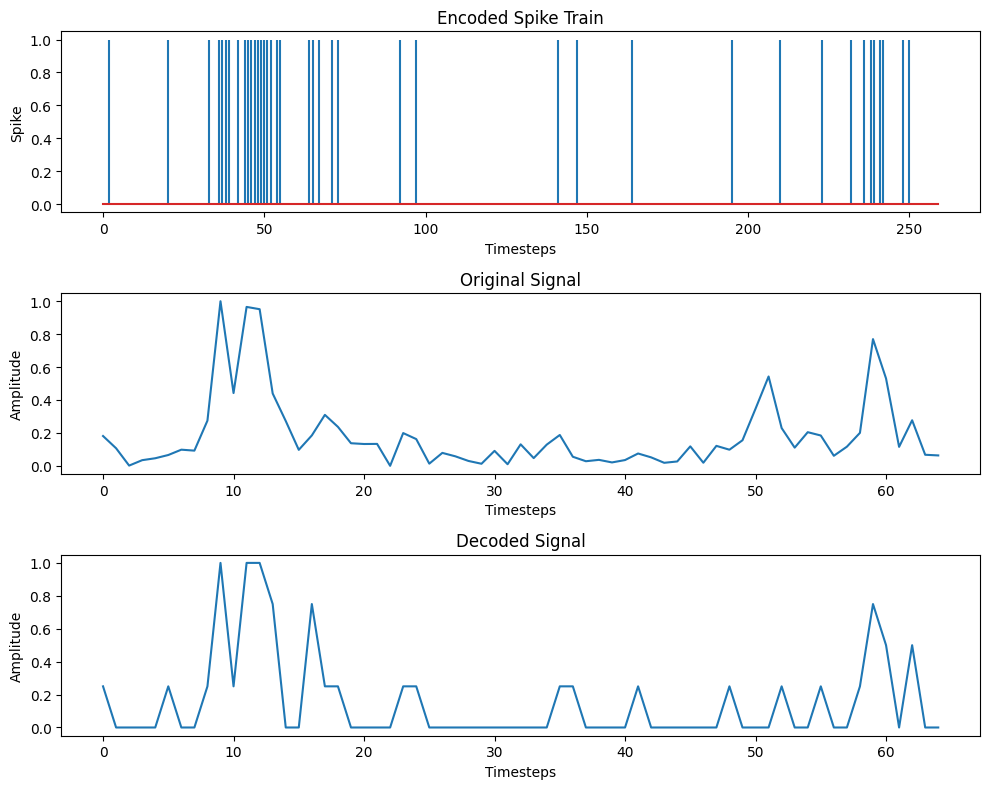

In [15]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_rate[0,0,0,:])

In [43]:
from encoder import PoissonEncoder

p_encoder = PoissonEncoder(interval_freq=4, random_seed=24)
encoded_data = p_encoder.encode(magnitudes)
decoded_rate = p_encoder.decode(encoded_data)

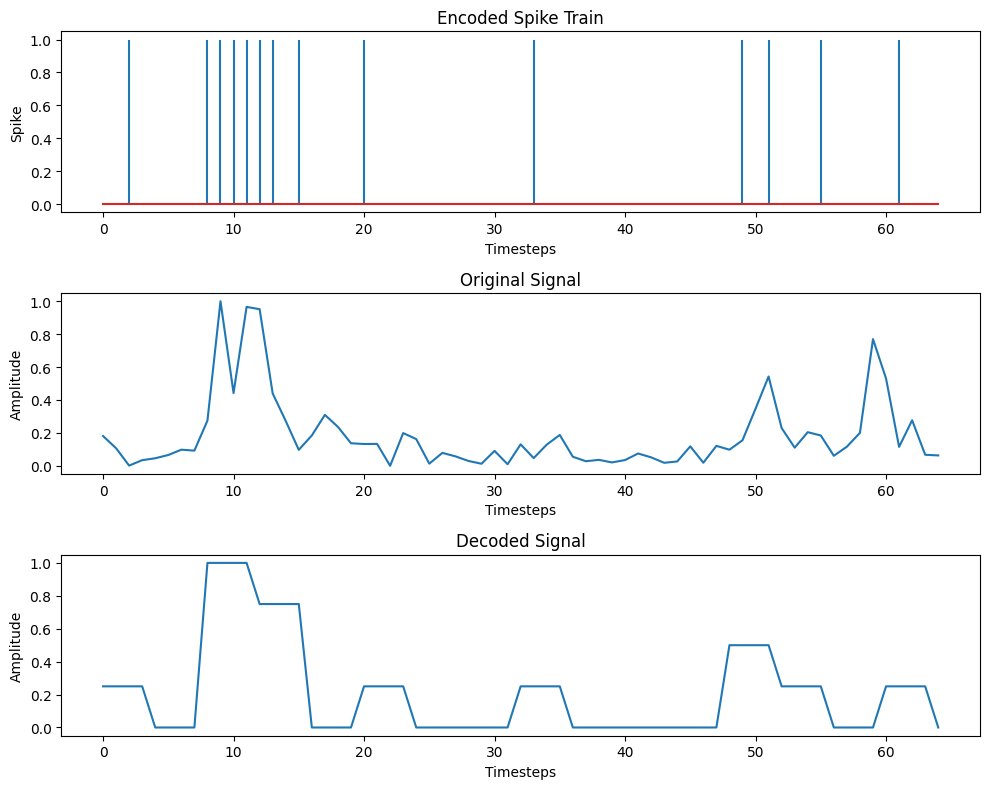

In [44]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_rate[0,0,0,:])

In [16]:
from encoder import StepForwardEncoder

sf_encoder = StepForwardEncoder(threshold=0.19606764001960716)
base = normalized_magnitudes.select(-1, 0).unsqueeze(-1)
encoded_data = sf_encoder.encode(magnitudes)
decoded_data = sf_encoder.decode(encoded_data, base=base)

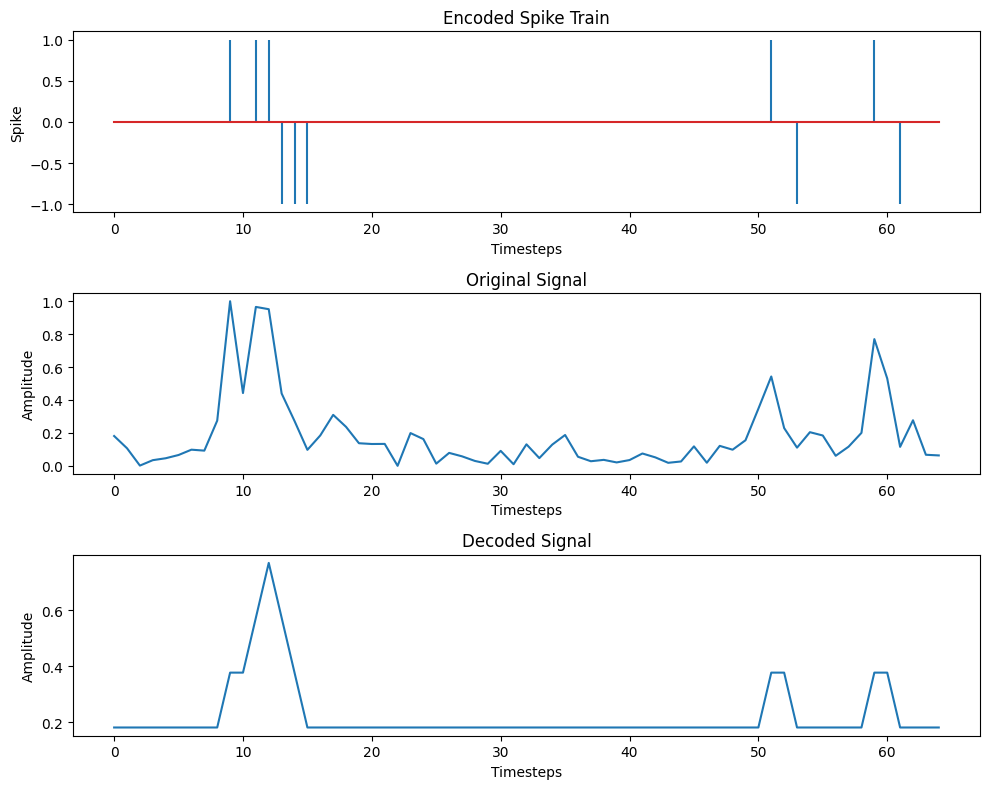

In [17]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_data[0,0,0,:])

In [18]:
from encoder import TBREncoder

tbr_encoder = TBREncoder(threshold=0.40992623011415186)
base, threshold = tbr_encoder.get_decode_parameters(normalized_magnitudes)
encoded_data = tbr_encoder.encode(magnitudes)
decoded_data = tbr_encoder.decode(encoded_data, base=base, threshold=threshold)

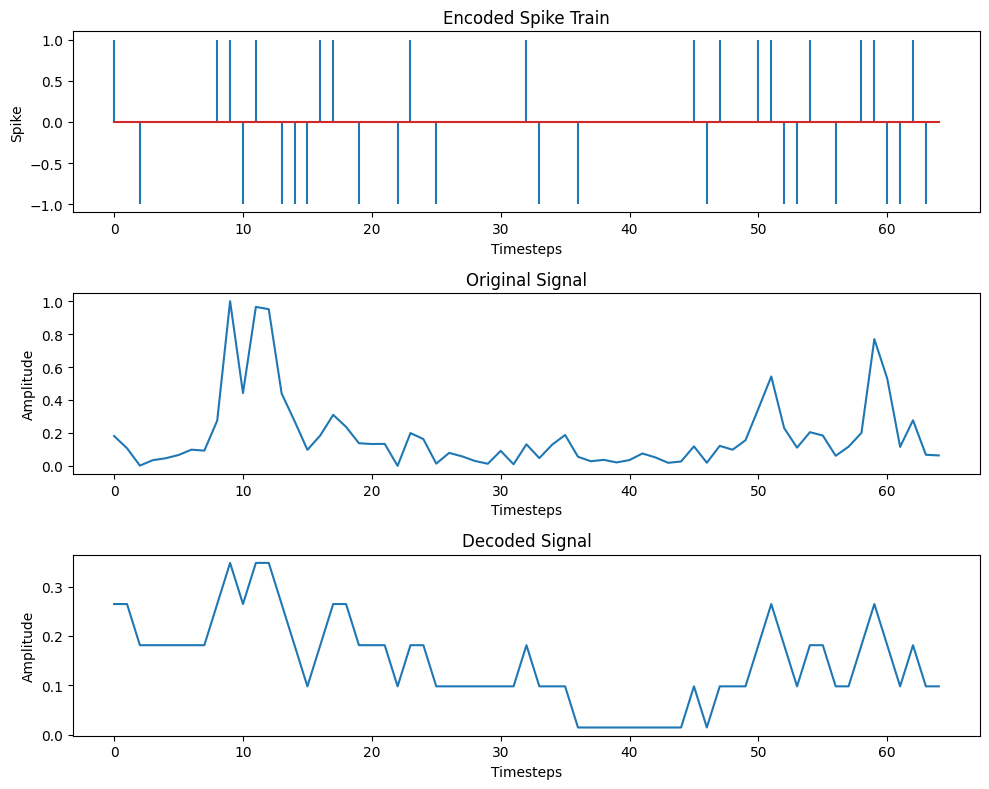

In [19]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_data[0,0,0,:])

In [20]:
from encoder import BSAEncoder

bsa_encoder = BSAEncoder(win_size=6, cutoff=0.15678260630598448, threshold=0.4054443922810268)
encoded_data = bsa_encoder.encode(magnitudes)
decoded_data = bsa_encoder.decode(encoded_data)

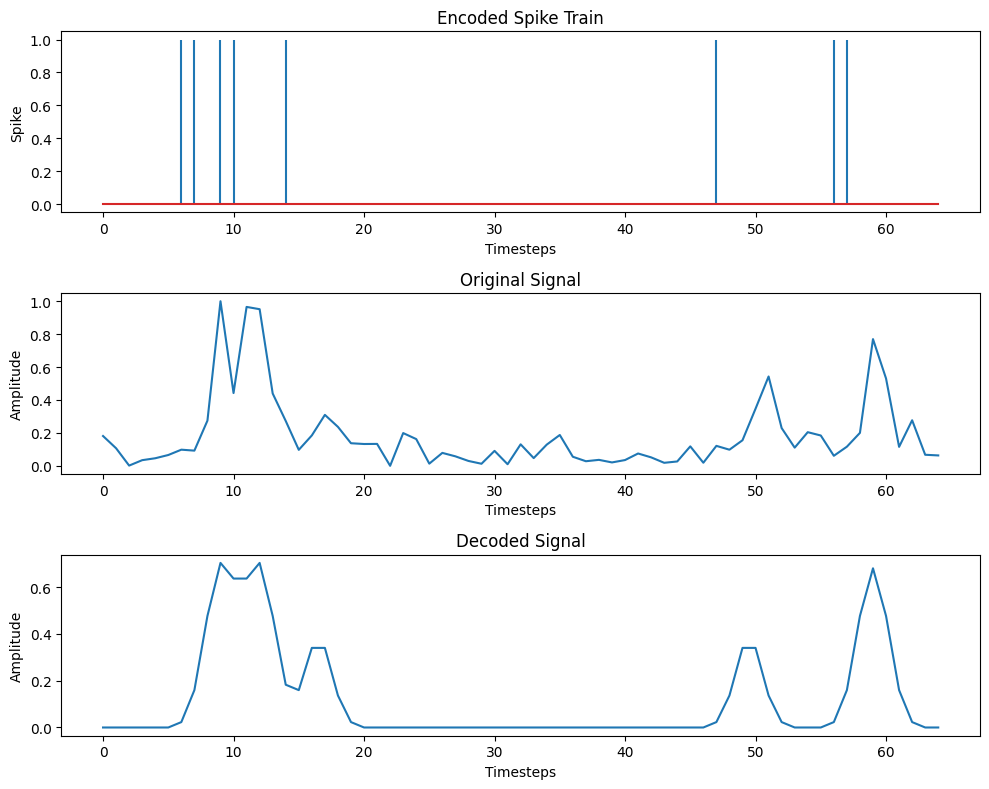

In [21]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_data[0,0,0,:])

In [45]:
from encoder import PhaseEncoderExpand

phase_encoder = PhaseEncoderExpand(phase_window=8)
encoded_data = phase_encoder.encode(normalized_magnitudes)
decoded_data = phase_encoder.decode(encoded_data)

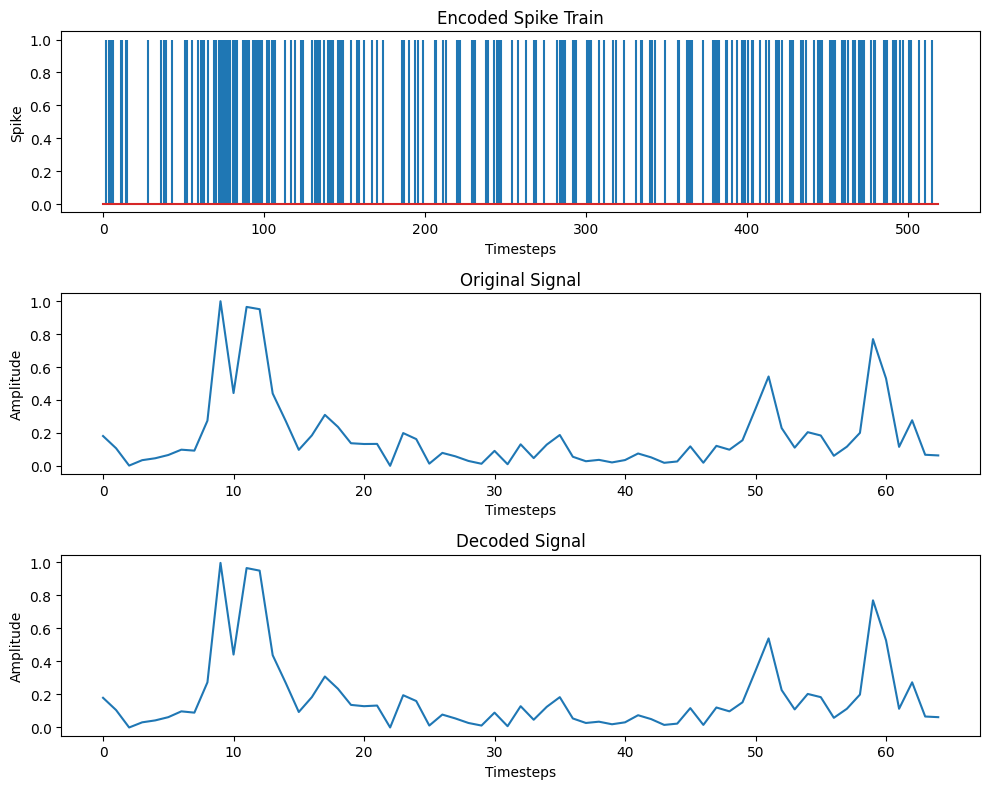

In [46]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_data[0,0,0,:])

In [77]:
from encoder import PhaseEncoder

phase_encoder = PhaseEncoder(phase_window=5)
encoded_data = phase_encoder.encode(normalized_magnitudes)
decoded_data = phase_encoder.decode(encoded_data)

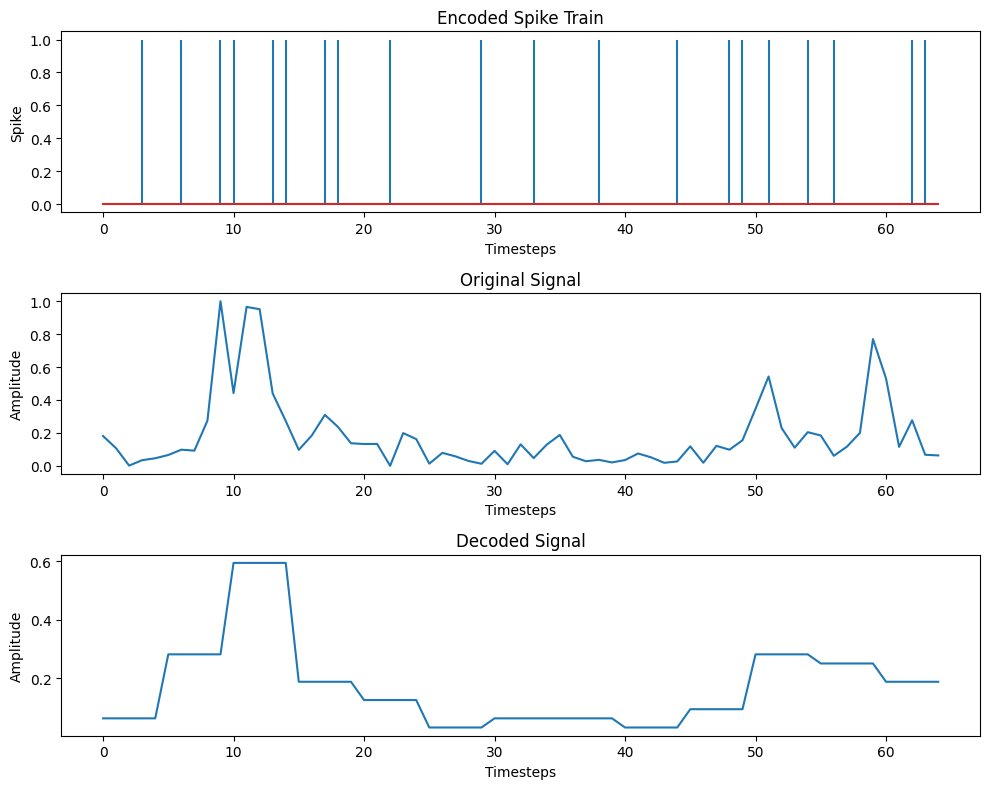

In [78]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_data[0,0,0,:])